<a href="https://colab.research.google.com/github/diegojeda/Bit-Optimization-ML/blob/master/Pruebas%20de%20Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
import pandas as pd
from scipy import stats
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno;

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
url = "https://raw.githubusercontent.com/diegojeda/Curso-Analytics---Drilling-Bits/master/Dataset/BaseLimpia.csv"

base = pd.read_csv(url,error_bad_lines=False)

In [4]:
from sklearn.metrics import r2_score , mean_squared_error

def tabla_result (modelos,X_test,y_test):
    '''
    modelos: Diccionario con los modelos a evaluar
    X_test : Matriz X con los valores de test
    y_test : Matriz y con los valores de test
    '''
    y_pred = []
    MSE = []
    MSE_lin = []
    R2 = []
    R2_lin = []
    
    for m_name,m in modelos:
        y=m.predict(X_test)
        y_pred.append(y)
        
        MSE.append(mean_squared_error(y_test,y))
        MSE_lin.append(mean_squared_error(np.exp(y_test),np.exp(y)))
        
        R2.append(r2_score(y_test,y))
        R2_lin.append(r2_score(np.exp(y_test),np.exp(y)))
        
    return (y_pred, MSE, R2, R2_lin, MSE_lin)

In [5]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Creamos las matrices para los modelos
X = base.drop('Log ROP', axis=1)
y = base[['Log ROP']]

# Dividimos los datos de manera aleatoria con el 25% para test y 75% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)


Seed = 1

dt = DecisionTreeRegressor(random_state=Seed)
ADABoo = AdaBoostRegressor(base_estimator = dt,random_state=Seed)




In [18]:
ADABoo.get_params()

{'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best'),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'mse',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': 1,
 'base_estimator__splitter': 'best',
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estim

In [19]:
# Definimos el grid de evaluacion para los hyperparametros del Bagging
grid_parametros = {
    "n_estimators" : range(1, 200,10),
    "base_estimator__max_features" : range(1, 22),
    "base_estimator__max_depth" : [1,2,3,4,5],
    "base_estimator__min_samples_leaf" : [0.06,0.08,0.1,0.2,0.5],
    "learning_rate" : [0.1,0.2,0.5,0.7,0.9]
                  }

# Instanciamos el grid de busqueda, realizando un 5-folds CV
grid_AdaBoost = GridSearchCV(estimator = ADABoo,
                                   #n_iter = 1000,
                                   param_grid  = grid_parametros,
                                   scoring="r2",
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   #return_train_score=True
                            )

# Ajustamos el la busqueda con los valores de train
grid_AdaBoost.fit(X_train,y_train)

Fitting 5 folds for each of 52500 candidates, totalling 262500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    6.6s


KeyboardInterrupt: ignored

In [ ]:
# Extraemos los mejores hyperparametros encontrados en la busqueda
best_hyperparametros = grid_AdaBoost.best_params_
print('Mejores Hyerparametros:\n', best_hyperparametros)

# Extraemos el mejor R2 del cross-validation
best_R2 = grid_AdaBoost.best_score_
print('Mejor R2 de CV:\n', best_R2)

# Extraemos el modelos con los mejores parametros
best_AdaBoost = grid_AdaBoost.best_estimator_

# Evaluamos el mejor modelo con los datos de test
test_R2 = best_AdaBoost.score(X_test,y_test)
print("R2 de Test del Mejor Modelo: {:.3f}".format(test_R2))

# Diccionario con el modelo
modelos = [("AdaBoost",best_AdaBoost)]

# Extraemos los resultados
y_pred, MSE, R2, R2_lin, MSE_lin = tabla_result(modelos,X_test,y_test)

# Presentamos los datos en una tabla
Res = {"Modelo":["AdaBoost"],
           "MSE":MSE,
           "R2":R2}
Res = pd.DataFrame(Res)
Res.set_index("Modelo",inplace=True)
Res

In [ ]:
# Construimos los graficos de valores reales Vs valores predichos por el modelo
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(y_test,y_pred[0],linestyle="none",marker="*", color="red", label="Test")
plt.plot(y_train,best_AdaBoost.predict(X_train),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 5], [0, 5], 'k-', lw=2)
plt.xlabel("Log ROP Real")
plt.ylabel("Log ROP Predicho")
plt.title("Modelo ADABoost\nR2:%f \nMSE:%f" %(R2[0],MSE[0]))
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(np.exp(y_test),np.exp(y_pred[0]),linestyle="none",marker="*", color="red", label="Test")
plt.plot(np.exp(y_train),np.exp(best_AdaBoost.predict(X_train)),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 60], [0, 60], 'k-', lw=2)
plt.xlabel("ROP Real (ft/hr)")
plt.ylabel("ROP Predicho (ft/hr)")
plt.title("Modelo ADABoost\nR2:%f \nMSE:%f" %(R2_lin[0],MSE_lin[0]))
plt.legend(loc="upper left");

In [20]:
import xgboost as xgb

XGB_Reg = xgb.XGBRegressor(objective = "reg:linear", n_estimators = 80, seed= 123)

XGB_Reg.fit(X_train,y_train)

[00:49:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=80,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [21]:
# Diccionario con el modelo
modelos = [("XGBOost",XGB_Reg)]

# Extraemos los resultados
y_pred, MSE, R2, R2_lin, MSE_lin = tabla_result(modelos,X_test,y_test)

# Presentamos los datos en una tabla
Res = {"Modelo":["XGBoost"],
           "MSE":MSE,
           "R2":R2}
Res = pd.DataFrame(Res)
Res.set_index("Modelo",inplace=True)
Res

,MSE,R2
Modelo,,
XGBoost,0.286154,0.678384


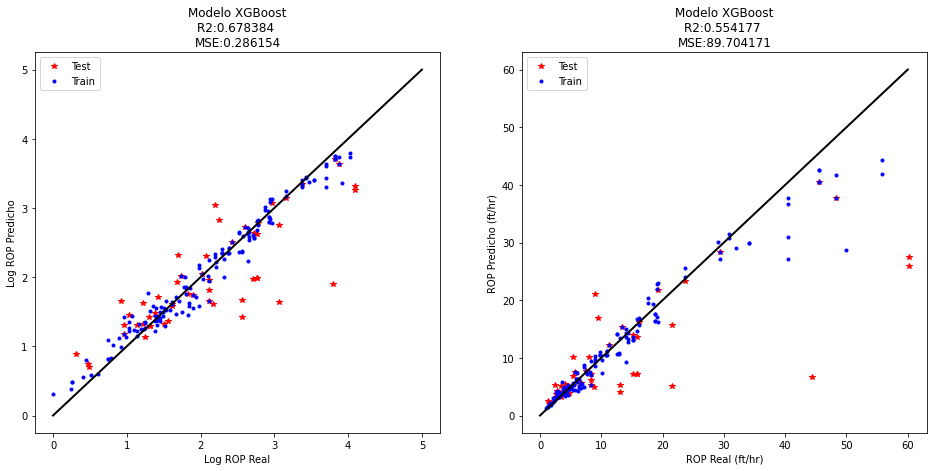

In [22]:
# Construimos los graficos de valores reales Vs valores predichos por el modelo
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(y_test,y_pred[0],linestyle="none",marker="*", color="red", label="Test")
plt.plot(y_train,XGB_Reg.predict(X_train),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 5], [0, 5], 'k-', lw=2)
plt.xlabel("Log ROP Real")
plt.ylabel("Log ROP Predicho")
plt.title("Modelo XGBoost\nR2:%f \nMSE:%f" %(R2[0],MSE[0]))
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(np.exp(y_test),np.exp(y_pred[0]),linestyle="none",marker="*", color="red", label="Test")
plt.plot(np.exp(y_train),np.exp(XGB_Reg.predict(X_train)),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 60], [0, 60], 'k-', lw=2)
plt.xlabel("ROP Real (ft/hr)")
plt.ylabel("ROP Predicho (ft/hr)")
plt.title("Modelo XGBoost\nR2:%f \nMSE:%f" %(R2_lin[0],MSE_lin[0]))
plt.legend(loc="upper left");

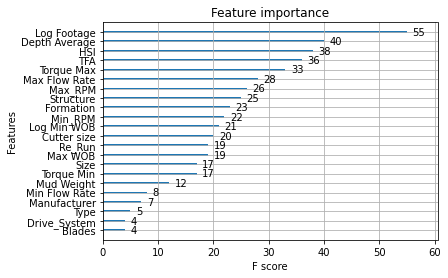

In [23]:
xgb.plot_importance(XGB_Reg)

# Tunned XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth" : [i for i in range(1,11)],
              "min_child_weight" : [i for i in range(1,11)],
              "gamma" : [i/10 for i in range(1,11)],
              "n_estimators" : [10,50,100,200,300,500,1000],
              'subsample':[i/10 for i in range(1,11)],
              'colsample_bytree':[i/10 for i in range(1,11)],
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
              "learning_rate" : [i/100 for i in range(10,110,10)]
              }

XGB_tunned = xgb.XGBRegressor()

grid_xgb = GridSearchCV(estimator = XGB_tunned,
                        param_grid = param_grid,
                        scoring="r2",
                        cv=5,
                        n_jobs=-1,
                        verbose=1)

grid_xgb.fit(X_train,y_train)

print("\n\nBest parameters found: ",grid_xgb.best_params_)
print("\nHighest R2 found: ", grid_xgb.best_score_)

In [91]:
# Diccionario con el modelo
modelos = [("XGBOost",grid_xgb.best_estimator_)]

# Extraemos los resultados
y_pred, MSE, R2, R2_lin, MSE_lin = tabla_result(modelos,X_test,y_test)

# Presentamos los datos en una tabla
Res = {"Modelo":["XGBoost"],
           "MSE":MSE,
           "R2":R2}
Res = pd.DataFrame(Res)
Res.set_index("Modelo",inplace=True)
Res

,MSE,R2
Modelo,,
XGBoost,0.290005,0.674056


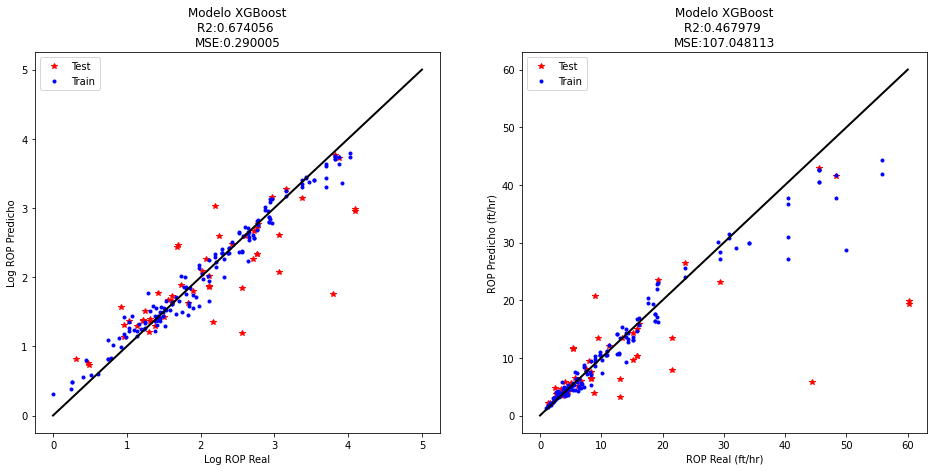

In [92]:
# Construimos los graficos de valores reales Vs valores predichos por el modelo
plt.figure(figsize = (16,7))

plt.subplot(121)
plt.plot(y_test,y_pred[0],linestyle="none",marker="*", color="red", label="Test")
plt.plot(y_train,XGB_Reg.predict(X_train),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 5], [0, 5], 'k-', lw=2)
plt.xlabel("Log ROP Real")
plt.ylabel("Log ROP Predicho")
plt.title("Modelo XGBoost\nR2:%f \nMSE:%f" %(R2[0],MSE[0]))
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(np.exp(y_test),np.exp(y_pred[0]),linestyle="none",marker="*", color="red", label="Test")
plt.plot(np.exp(y_train),np.exp(XGB_Reg.predict(X_train)),linestyle="none",marker=".", color="blue",label="Train")
plt.plot([0, 60], [0, 60], 'k-', lw=2)
plt.xlabel("ROP Real (ft/hr)")
plt.ylabel("ROP Predicho (ft/hr)")
plt.title("Modelo XGBoost\nR2:%f \nMSE:%f" %(R2_lin[0],MSE_lin[0]))
plt.legend(loc="upper left");

In [93]:
grid_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=3, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-07, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)